In [1]:
import numpy as np
import torch

## Wyzwanie
Perceptron dla obecnych sieci neuronowych jest jak Australopitek dla Homo sapiens - możemy się śmiać, że sieć kiedyś była taka prymitywna, ale bez zrozumienia niej - nie zrozumiemy całego skomplikowania nowoczesnych architektur. Twoim zadaniem będzie implementacja perceptronu, a także jego nauka od zera. Wyniki zweryfikujesz implementując na końcu taką samą sieć w [Pytorchu](https://docs.pytorch.org/docs/stable/index.html).

## Jak zrobić zadanie
0. Dane są te same co w poprzednim zadaniu - [Bank Marketing](https://archive.ics.uci.edu/dataset/222/bank+marketing)
1. Wykorzystaj wiedzę z poprzedniego notebooka (jak i kod, jeśli się da) do przygotowania danych. Pamiętaj o podziale na zbiory train, val i test. Przeskaluj dane używając StandardScaler lub innych, oczywiście unikając wycieku danych.
2. Możecie ograniczyć się do dwóch cech wejściowych - wybranych wedle uznania - do celów zadania (np. dwie cechy łatwiej jest zwizualizować)
3. Niżej są podane instrukcje (symbol ⚡ oznacza, że coś trzeba zaimplementować) - najlepiej rób je sekwencyjnie.

przydatne materiały:
* [deep_learning_60min_blitz](https://docs.pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html),
* [zrozumienie under/overfitting](https://mlu-explain.github.io/bias-variance/),
* [SUPER tutorial(e)](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial2/Introduction_to_PyTorch.html),
* [Mathematics of neural networks in machine learning](https://en.wikipedia.org/wiki/Mathematics_of_neural_networks_in_machine_learning),
* [Pozycja 53 -> rozdziały 2 (fenomenalny),11](https://docs.google.com/spreadsheets/d/1UnjOh5TYgNiFBw9jsM6mJrp68uEdzeW3iIi6Ew0xfgQ/edit?gid=0#gid=0),
* [Optymizatory & uczenie paczkami](https://arxiv.org/pdf/1609.04747)


### Problemy w uczeniu maszynowym

Przypomnijmy sobie jeszcze czym się różni zadanie **klasyfikacji** od **regresji**. Jak już zapewne wiesz, nasze dane można podzielić na zbiór cech (X) oraz na zbiór zmiennych docelowych (y). Ten drugi może kodować informacje o tym, jaka jest klasa przynależności (np. *chory ∈ {true, false}*, *kolor ∈ {zielony, niebieski, czerwony}*), lub jaka jest wartość pewnej cechy (np. *temperatura ∈ ℜ*, *punkty z egzaminu* ∈ 𝒵). W zadaniu klasyfikacji mamy do czynienia z kategoriami, które są dyskretne, a w zadaniu regresji zmienne docelowe są zwykle ciągłe. Dlaczego to istotne? W trakcie pracy nad notebookiem pewnie zdasz sobie sprawę, że nie można do problemu klasyfikacji użyć straty najmniejszych kwadratów - co byłoby odpowiednie w problemie regresji.

## 1. Perceptron*
Wejdziemy w trochę matematyki (serio, matma jest niezbędna jeśli chcesz być Pro AI engineer'em). Najprostszy perceptron opisany jest wzorem

$$A = σ(𝑤^TX + b) = σ(Z) = (a_1, ..., a_{m-1})$$
gdzie


*   σ to funkcja aktywacji
*   $X$ to macierz cech, wymiaru $k \times m$ ($=$ liczba cech $\times$ liczba próbek)
*   𝑤 to macierz wag z $k$ wartościami (wyuczalne parametry)
*   b to skalar, zwany *biasem* (wyuczalny parametr)
*   $A$ to wyjściowy wektor o długości $m$

Popularne funkcje aktywacji:
- Relu: $f(Z) = max(Z, 0)$
- Sigmoid: $f(Z) = \frac{1}{1 + e^{-Z}}$

Jednak w tym zadaniu poprawna będzie tylko jedna - musisz sam(a) wybrać która to będzie i dlaczego. (Hint: zastanów się, *co oznacza wyjście sieci*, i dlaczego ta "niepoprawna" funkcja aktywacji będzie psuła sieć)

*W rzeczywistości nie będzie to [stricte perceptron](https://pl.wikipedia.org/wiki/Perceptron), ponieważ nie będziemy implementować skokowej funkcji straty.

Poprawnym wyborem jest sigmoid, bo jest to zadanie klasyfikacji binarnej, a sigmoid zwraca wynik z przedziału [0,1].

In [2]:
!pip install ucimlrepo

In [3]:
import numpy as np
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

bank_marketing = fetch_ucirepo(id=222)

X = bank_marketing.data.features
y = bank_marketing.data.targets.to_numpy().ravel()
y = (y == "yes").astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=671, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=6677, stratify=y_train
)
def process_features(df):
  df = df.copy()
  df["previous_contact"] = (df["pdays"] > 0).astype(int)
  df = df.drop(columns=["previous", "pdays", "month"])
  return df

X_train = process_features(X_train)
X_test = process_features(X_test)
X_val = process_features(X_val)

num_features = X_train.select_dtypes(include=["int64"]).columns # kolumny numeryczne
cat_features = X_train.select_dtypes(include=["object"]).columns # kolumny kategorii

num_pipeline = Pipeline(steps=[
  ("imputer", SimpleImputer(strategy="median")), # brakujace wartosci numeryczne wypelniam mediana
  ("scaler", StandardScaler()) # standaryzacja przyda sie dla modeli
])

cat_pipeline = Pipeline(steps=[
  ("imputer", SimpleImputer(strategy="constant", fill_value="unknown")), # brakujace kategorie wypelniam unknown
  ("onehot", OneHotEncoder(handle_unknown="ignore")) # zamiana kategorii na liczby, tego wymagaja niektore modele
])

preprocessor = ColumnTransformer(
  transformers=[
    ("num", num_pipeline, num_features),
    ("cat", cat_pipeline, cat_features),
  ]
)

preprocessor.fit(X_train)
X_train = preprocessor.transform(X_train)
X_test = preprocessor.transform(X_test)
X_val = preprocessor.transform(X_val)

### ⚡ Zaimplementuj tutaj perceptron

In [4]:
class Perceptron:
  def __init__(self, k: int, seed: int = 2137):
    rng = np.random.default_rng(seed)
    self.w = rng.normal(-0.01, 0.01, size=k)
    self.b = 0.0

  def forward(self, X: np.ndarray) -> np.ndarray:
    A = X @ self.w + self.b
    #print(f"Forwarding, shape X {X.shape} w {self.w.shape}, A {A.shape}")
    return self.sigmoid(A)

  def sigmoid(self, A: np.ndarray) -> np.ndarray:
    return 1.0 / (1.0 + np.exp(-A))

### Przejście w przód i w tył

Następnym zadaniem jest wyuczenie naszych macierzy. Prawdopodobnie twoje wartości są losowe (mam nadzieję, że macierz nie jest wypełniona zerami), przez co i sieć daje losowe wyniki. To, co możemy wydzielić jako atomową operację w procesie uczenia sieci składa się z kroków:
1. Forward propagation (przejście w przód) - wymnożenie wejściowych cech przez wagi sieci
2. Loss (obliczanie straty) - obliczamy jaki jest błąd popełniany przez sieć
3. Backward propagation (przejście w tył) - propagacja gradientu i **aktualizacja** wag sieci

Proces uczenia zachodzi w N epokach.

Pytanie filozoficzne: czy strata może być równa zero? czy możemy wyczyć idealną sieć? Jak sądzisz, w jakich warunkach tak może być? (warto na takie przemyślenie poświęcić >=30 sekund).

Matematycznie ma to taką postać:
* Fp: $A = σ(𝑤^TX + b) = σ(Z)$ (to było już)
* Loss: L = $\frac{1}{M} g(A, Gt)$, gdzie $Gt$ to prawdziwe, poprawne wartości, a $g$ to odpowiednia dla problemu funkcja straty. Dzielimy przez liczbę próbek, bo chcemy uzyskać średnią wartość błędu,
* Bp: niestety nie zachodzi w jednym kroku. Rozpiszmy to

$$L = \frac{1}{M} g(A, Gt)$$  -> mamy nasz wyliczony loss (musimy mieć wartość skalarną, dlatego uśredniamy startę)
$$\frac{∂L}{∂𝑤} = ? $$ -> to chcemy wyliczyć (zaraz, zaraz powiemy po co)
$$ \frac{∂L}{∂𝑤} = \frac{∂L}{∂A} \frac{∂A}{∂Z} \frac{∂Z}{∂w}$$ -> to wynika z [twierdzenia łańcuchowego](https://en.wikipedia.org/wiki/Chain_rule)

Jaki mamy deal z tego? Otóż będziemy obliczać pochodne zmiany funkcji starty względem parametrów sieci tak, by je dostosowywać w kierunku zmniejszenia się tej straty (spadek wzdłuż gradientu [link text](https://en.wikipedia.org/wiki/Gradient_descent)). Aktualizacja wag sieci, w epoce n, ma postać:

$$𝑤^{n + 1} = 𝑤^{n} - \alpha \frac{∂L}{∂𝑤}$$

gdzie $\alpha$ jest hiperparameterem (czyli taką wartością, która jest ustalana z góry, przed uruchomieniem treningu), zwykle o wartościach $0.01$, czy $0.001$.
 Decyduje ona o szybkości treningu.

 Twoim zadaniem jest teraz ⚡ implementacja klasy do trenowania, dla której docelowo chcemy tylko wywołać funkcję *train*, a w środku ma zachodzić cała magia. Funkcja *predict* ma służyć do predykcji kategorii dla próbek testowych.

In [51]:
class Trainer:
  def __init__(self, perceptron: Perceptron, n_epochs: int, lr: float, batch_size: int = 64, seed: int = 67):
    self.perceptron = perceptron
    self.n_epochs = n_epochs
    self.lr = lr
    self.seed = seed
    self.batch_size = batch_size
    self.history = []

  def loss(self, A: np.array, y: np.ndarray): # oblicza stratę między wyjściem sieci a ground truth
    # H(p, q) = - E p(x) * log q(x)
    eps = 1e-12
    A = np.clip(A, eps, 1.0 - eps)
    return float(-1 * np.mean(y * np.log(A) + (1.0 - y) * np.log(1.0 - A)))

  def confusion_matrix(self, A: np.ndarray, y: np.ndarray):
    tn = int(np.sum((y == 0) & (A == 0)))
    fp = int(np.sum((y == 0) & (A == 1)))
    fn = int(np.sum((y == 1) & (A == 0)))
    tp = int(np.sum((y == 1) & (A == 1)))
    return (tn, fp, fn, tp)

  def backward(self, A: np.ndarray, y: np.ndarray, X: np.ndarray):
    m = X.shape[0]
    dZ = A - y
    #print(f"Backwarding A {A.shape} y {y.shape} dZ {dZ.shape}")
    # licz gradienty
    self.dw = (X.T @ dZ) / m
    self.db = float(np.sum(dZ) / m)

  def update_weights(self):
    self.perceptron.w = self.perceptron.w - self.lr * self.dw
    self.perceptron.b = self.perceptron.b - self.lr * self.db

  def evaluate(self, X: np.ndarray, y: np.ndarray):
    A = self.predict(X)
    m = A.shape[0]
    loss = self.loss(A, y)
    y_pred = (A >= 0.5).astype(int)
    acc = float(np.mean(y_pred == y))
    (tn, fp, fn, tp) = self.confusion_matrix(y_pred, y)
    precision = tp / (tp + fp) if tp+fp > 0 else 0
    recall = tp / (tp + fn) if tp+fn > 0 else 0
    f1 = (2 * precision * recall / (precision + recall)) if precision + recall > 0 else 0
    (tn, fp, fn, tp) = (tn/m, fp/m, fn/m, tp/m) # zapisz jako %
    return loss, acc, (tn, fp, fn, tp), precision, recall, f1

  def train(self, X: np.ndarray, y: np.ndarray): # wykonuje trenowanie w N epokach
    for i in range(self.n_epochs):
      for X_batch, y_batch in self.get_minibatches(X, y, self.batch_size, True, self.seed + i):
        A = self.predict(X_batch)
        self.backward(A, y_batch, X_batch)
        self.update_weights()
      self.save_epoch_data(i+1, X, y)

  def predict(self, X: np.ndarray) -> np.ndarray: # funkcja na wykonanie inferencji
    A = self.perceptron.forward(X)
    return A

  def get_minibatches(self, X: np.ndarray, y: np.ndarray, batch_size: int, shuffle: bool = True, seed: int = 67):
    m = X.shape[0]
    idx = np.arange(m)
    if shuffle:
      rng = np.random.default_rng(seed)
      rng.shuffle(idx)
    for start in range(0, m, batch_size):
      batch_idx = idx[start:start + batch_size]
      yield X[batch_idx], y[batch_idx]

  def save_epoch_data(self, i: int, X: np.array, y: np.ndarray):
    if i%100 != 0:
      return
    loss, acc, cm, precision, recall, f1 = self.evaluate(X, y)
    val_loss, val_acc, val_cm, val_prec, val_rec, val_f1 = self.evaluate(X_val, y_val)
    row = {
      "epoch": i,
      "train_loss": loss,
      "train_acc": acc,
      "train_cm": cm,
      "train_precision": precision,
      "train_recall": recall,
      "train_f1": f1,
      "val_loss": val_loss,
      "val_acc": val_acc,
      "val_cm": val_cm,
      "val_precision": val_prec,
      "val_recall": val_rec,
      "val_f1": val_f1,
    }
    self.history.append(row)
    print(f"Epoch {i}: loss {loss} val loss {val_loss}")

In [52]:
features = 4
X_train = X_train[:, :features]
X_test  = X_test[:, :features]
X_val  = X_val[:, :features]

perceptron = Perceptron(X_train.shape[1])
trainer = Trainer(perceptron, n_epochs = 1000, lr = 0.01, batch_size = 5000)
trainer.train(X_train, y_train)

Epoch 100: loss 0.3584339697891669 val loss 0.3621040841480411
Epoch 200: loss 0.316641533937792 val loss 0.3217163456335636
Epoch 300: loss 0.30579017208436077 val loss 0.31168660340428833
Epoch 400: loss 0.30211876479925676 val loss 0.3085215711274943
Epoch 500: loss 0.30068974894271233 val loss 0.30746415064826965
Epoch 600: loss 0.3000593469618997 val loss 0.30702855107098
Epoch 700: loss 0.29977788708412667 val loss 0.3068945383951701
Epoch 800: loss 0.2996542038549509 val loss 0.3069167967171199
Epoch 900: loss 0.29958890969775626 val loss 0.3069273863485227
Epoch 1000: loss 0.2995579994105967 val loss 0.30698035158245573


In [53]:
test_res = trainer.evaluate(X_test, y_test)
t_loss, t_acc, t_cm, t_prec, t_rec, t_f1 = test_res
print(t_loss, t_f1, t_prec, t_rec)

0.306674588561155 0.25272547076313184 0.5916473317865429 0.16068052930056712


## HINTS
Hint1: na kartce rozpisz sobie krok po kroku przejście w przód. Najlepiej użyj tej samej konwencji nazewniczej zmiennych, lub zdefiniuj zmienne pomocniczne. Rozwiń jaki będzie konkretny wzór na pochodne: $\frac{∂L}{∂A}$, $\frac{∂A}{∂z}$ i  $\frac{∂z}{∂w}$. Jak już przez to przebrniesz, to przepisanie tego do Pythona powinno być bezbolesne i skuteczne.

Hint2: Funkcje straty, które powinieneś/powinnaś rozważać to [MSE](https://en.wikipedia.org/wiki/Mean_squared_error) lub [BCE](https://www.geeksforgeeks.org/deep-learning/binary-cross-entropy-log-loss-for-binary-classification/). Jeśli rozpisanie gradientu jest dla ciebie nie do przejścia, to posłuż się "gotowcem", ale nadal spróbuj samodzielnie przepisać na kod.

Hint3: do mnożenia macierzy w numpy używamy ```np.dot``` lub ```@```.

Hint4: początkowe wartości macierzy $𝑤$ mogą być zaincjalizowane losowymi wartościami z niewielkiego zakresu (np. $[-0.01, 0.01]$)

Hint5: wartości wejściowe powinny być ustandaryzowane (dla poprawy jakości spadku wzdłuż gradientu)

### Uczenie paczkami
Być może już zauważyłeś/łaś, że wymnażanie wielkiej macierzy $X$ w pojedynczym kroku jest problematyczne - jeśli nie w tym eksperymencie, to w następnym. Istnieją różne strategie do aktualizacji parametrów:
* batch gradient descent - aktualizacja parametrów odbywa się po przejściu wszystkich próbek przez sieć, a gradient jest uśredniany (to, co pewnie masz teraz)
* stochastic gradient descent - aktualizacja parametrów następuje po każdej pojedynczej próbce (podejście na drugim końcu spektrum)
* mini-batch stochastic gradient descent - podział wszystkich próbek na paczki o wielkości $M$, i aktualizacja gradientu po każdej paczce (podejście "po środku" dwóch poprzednich)

Zastanów się, które podejście jest odpowiednie i w funkcji *train* ⚡ doimplementuj odpowiedni podział (lub nie?) macierzy danych $X$.

Nic nie stoi na przeszkodzie, by udokumentować zachowanie sieci dla każdej strategii (możesz to zawrzeć w dalszej sekcji eksperymentów).


### Wnioski
Mniejszy batch size powodował, że bardzo szybko malał loss, ale ogólnie trening trwał dłużej. Proporcjonalnie, duży batch size zajmował mniej czasu, ale dłużej dochodził do dobrych wyników. Wielkość macierzy była mała, więc mnożenie nawet całej nie stanowiło problemu.

Zostałem przy batch size 5000, żeby trening nie trwał zbyt długo.

### Śledzenie przebiegu uczenia

W praktyce, sam spadek wzdłuż gradientu nie gwarantuje, że dostaniemy optymalne wagi sieci. W celu weryfikacji, czy nie doszło do **przeuczenia**, twoim ⚡ kolejnym krokiem będzie dodanie do klasy *Trainer* funkcji, które zapiszą, na końcu każdej epoki

 (a) istotne metryki w kontekście zadania,

(b) wartość straty

zarówno dla zbioru treningowego, jak i walidacyjnego - najlepiej w postaci wykresu. Na ich podstawie zdiagnozuj, czy model podlega **niedouczeniu / underfitting**, **przeuczeniu / overfitting**, a może jest względnie "dobry".  

## Wykresy

(0.306674588561155, 0.8888233559422, (0.870023591860808, 0.012975523444411679, 0.09820112061338838, 0.01879976408139192), 0.5916473317865429, 0.16068052930056712, 0.25272547076313184)
[{'epoch': 100, 'train_loss': 0.3584339697891669, 'train_acc': 0.8880594067227554, 'train_cm': (0.8736027175415728, 0.00940079788284552, 0.10253979539439902, 0.014456689181182605), 'train_precision': 0.6059602649006622, 'train_recall': 0.12356515867656989, 'train_f1': 0.2052720134604599, 'val_loss': 0.3621040841480411, 'val_acc': 0.8862559241706162, 'val_cm': (0.8725118483412322, 0.010584518167456557, 0.10315955766192733, 0.013744075829383886), 'val_precision': 0.564935064935065, 'val_recall': 0.11756756756756757, 'val_f1': 0.19463087248322147}, {'epoch': 200, 'train_loss': 0.316641533937792, 'train_acc': 0.8888098905873524, 'train_cm': (0.8724177430185251, 0.010585772405893274, 0.10060433700675435, 0.01639214756882727), 'train_precision': 0.6076134699853587, 'train_recall': 0.1401080351114112, 'train_f1'

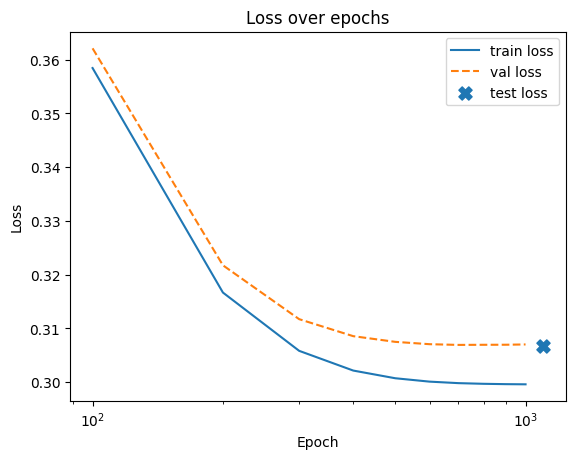

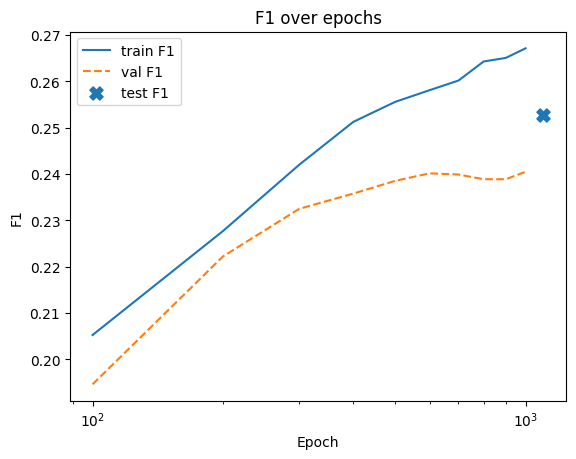

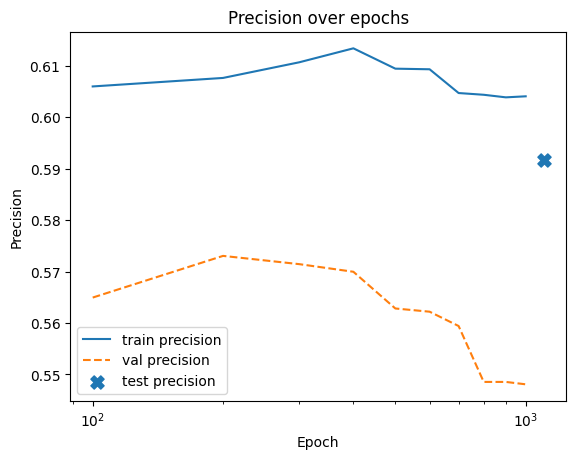

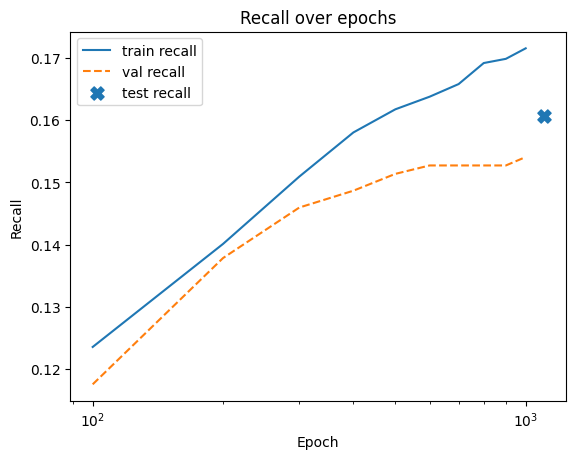

In [54]:
import matplotlib.pyplot as plt

def plot_eval(history, test_results):
  epochs = [h["epoch"] for h in history]

  train_loss = [h["train_loss"] for h in history]
  val_loss   = [h["val_loss"] for h in history]
  train_f1 = [h["train_f1"] for h in history]
  val_f1   = [h["val_f1"] for h in history]
  train_prec= [h["train_precision"] for h in history]
  val_prec   = [h["val_precision"] for h in history]
  train_rec = [h["train_recall"] for h in history]
  val_rec   = [h["val_recall"] for h in history]

  test_loss, test_acc, test_cm, test_prec, test_rec, test_f1 = test_results
  x_test = epochs[-1] * 1.1

  plt.figure()
  plt.plot(epochs, train_loss, label="train loss")
  plt.plot(epochs, val_loss, label="val loss", linestyle="--")
  plt.scatter([x_test], [test_loss], label="test loss", marker="X", s=90, zorder=5)
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.xscale("log")
  plt.title("Loss over epochs")
  plt.legend()
  plt.show()

  plt.figure()
  plt.plot(epochs, train_f1, label="train F1")
  plt.plot(epochs, val_f1, label="val F1", linestyle="--")
  plt.scatter([x_test], [test_f1], label="test F1", marker="X", s=90, zorder=5)
  plt.xlabel("Epoch")
  plt.ylabel("F1")
  plt.xscale("log")
  plt.title("F1 over epochs")
  plt.legend()
  plt.show()

  plt.figure()
  plt.plot(epochs, train_prec, label="train precision")
  plt.plot(epochs, val_prec, label="val precision", linestyle="--")
  plt.scatter([x_test], [test_prec], label="test precision", marker="X", s=90, zorder=5)
  plt.xlabel("Epoch")
  plt.ylabel("Precision")
  plt.xscale("log")
  plt.title("Precision over epochs")
  plt.legend()
  plt.show()

  plt.figure()
  plt.plot(epochs, train_rec, label="train recall")
  plt.plot(epochs, val_rec, label="val recall", linestyle="--")
  plt.scatter([x_test], [test_rec], label="test recall", marker="X", s=90, zorder=5)
  plt.xlabel("Epoch")
  plt.ylabel("Recall")
  plt.xscale("log")
  plt.title("Recall over epochs")
  plt.legend()
  plt.show()

test_results = trainer.evaluate(X_test, y_test)
print(test_results)
print(trainer.history)
plot_eval(trainer.history, test_results)

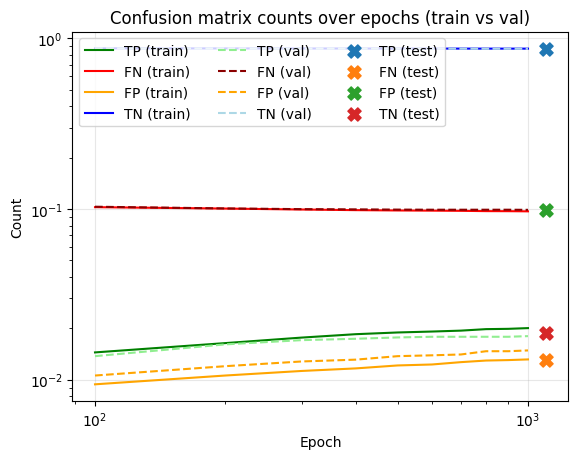

In [55]:
def plot_cm(history, test_results):
  epochs = [h["epoch"] for h in history]
  tr_tn = [h["train_cm"][0] for h in history]
  tr_fp = [h["train_cm"][1] for h in history]
  tr_fn = [h["train_cm"][2] for h in history]
  tr_tp = [h["train_cm"][3] for h in history]
  va_tn = [h["val_cm"][0] for h in history]
  va_fp = [h["val_cm"][1] for h in history]
  va_fn = [h["val_cm"][2] for h in history]
  va_tp = [h["val_cm"][3] for h in history]
  test_loss, test_acc, test_cm, test_prec, test_rec, test_f1 = test_results
  x_test = epochs[-1] * 1.1
  plt.figure()

  plt.plot(epochs, tr_tp, label="TP (train)", linestyle="-", color="green")
  plt.plot(epochs, tr_fn, label="FN (train)", linestyle="-", color="red")
  plt.plot(epochs, tr_fp, label="FP (train)", linestyle="-", color="orange")
  plt.plot(epochs, tr_tn, label="TN (train)", linestyle="-", color="blue")

  plt.plot(epochs, va_tp, label="TP (val)", linestyle="--", color="lightgreen")
  plt.plot(epochs, va_fn, label="FN (val)", linestyle="--", color="darkred")
  plt.plot(epochs, va_fp, label="FP (val)", linestyle="--", color="orange")
  plt.plot(epochs, va_tn, label="TN (val)", linestyle="--", color="lightblue")

  plt.scatter([x_test], [test_cm[0]], label="TP (test)", marker="X", s=90, zorder=5)
  plt.scatter([x_test], [test_cm[1]], label="FN (test)", marker="X", s=90, zorder=5)
  plt.scatter([x_test], [test_cm[2]], label="FP (test)", marker="X", s=90, zorder=5)
  plt.scatter([x_test], [test_cm[3]], label="TN (test)", marker="X", s=90, zorder=5)

  plt.xlabel("Epoch")
  plt.ylabel("Count")
  plt.xscale("log")
  plt.yscale("log")
  plt.title("Confusion matrix counts over epochs (train vs val)")
  plt.legend(ncol=3)
  plt.grid(True, alpha=0.3)
  plt.show()


plot_cm(trainer.history, test_results)



### ⭐ Ekstra zadanie - optymizator
Spadek wzdłuż gradientu zawsze bierze pod uwagę tylko aktualne wartości gradientów, przez co może być podatny na gwałtowne zmiany. W celu wydajniejszego trenowania stosuje się [optymizatory](https://arxiv.org/pdf/1609.04747) typu *Momentum* czy *Adagrad* (choć w praktyce zwykle *Adam*). Zaimplementuj wybrany optimzator i porównaj, jak uczy się sieć z i bez, oraz jak zmieniają się wartości wag (np. możesz logować bezwzględną, uśrednioną wartość zmian wag).

### ⚡ Eksperymenty
Zbadaj skuteczność sieci oraz oceń, czy dobrze się generalizuje na podstawie krzywych uczenia. Dokładniej, zbadaj co najmniej **3 wartości współczynnika uczenia** i **3 wartości liczby epok**. Zapisz swoje obserwacje. Nie przejmuj się, jeśli po nieudanych próbach twoja sieć nie chce się uczyć - jeśli czujesz, że wiesz w czym leży błąd, to zapisz te obserwacje.

## Wnioski
Epoki: 1000, Learning rate: 0.01
- Precyzja bardzo wacha się, aż zatrzymuje się w okolicy 0.6 dla train.
- Precyzja jest dużo wyższa dla train niż dla val.
- Recall stabilnie rośnie, choć coraz wolniej.
- W okolicy 100 epoki wyniki train zaczynają oddalać się od val i test - tam może zaczynać się przetrenowanie.
- Uczenie trwało 6 sekund.
- W okolicy 100 epoki spadek lossu bardzo zmalał.
- Testowy F1 0.25, precyzja 0.6, recall 0.15.

Epoki: 1000, Learning rate: 0.001
- Uczenie trwało 8 sekund
- Dopiero po pewnej liczbie epok (koło 50) model zaczął znacząco poprawiać wyniki. Było za mało epok, żeby osiągnął taki wynik jak poprzednia próba.
- Testowy F1 0.2, precyzja 0.6, recall 0.1

Epoki: 10000, Learning rate: 0.001
- Uczenie trwało minutę
- Wychodzi na to, że epoki i lr powinny być zmieniane odwrotnie proporcjonalne. Żeby nadrobić wolniejsze uczenie trzeba zwiększyść ilość epok, co ma sens.
- Testowy F1 0.25, precyzja 0.6, recall 0.15
- Wyniki nie przebiły próby z większym lr, a uczenie było dużo dłuższe.

Epoki: 1000, Learning rate 0.1
- Uczenie trwało 5s
- Co dziwne, precyzja zbioru walidacyjnego była znacząco niższa niż testowa. Może zbiór walidacyjny wylosował się trudny, bo wydaje się być odpowiednio podzielony.
- Widać tu przetrenowanie, wyniki test są bardziej oddalone od train niż w poprzednich próbach. Ujawnia się to od 100 epoki, więc byłaby to optymalna wartość.
- Testowy F1 0.25, precyzja 0.59, recall 0.16
- Ostateczne wyniki są podobne do poprzednich, ale wyniki train przebijają te testowe, czyli model nie generalizuje dobrze.


## 2. Implementacja sieci w pytorchu
Następnie ⚡ zaimplementujesz perceptron korzystając z biblioteki pytorch w celu weryfikacji wyników.

### Tensory
Są to struktury danych zbliżone do macierzy **np.array**, tyle, że mogą być przenoszone na karty graficzne, które są niezbędne do wyuczenia głębokich sieci. W następującej części zadania będziesz musiał(a) opanować pracę z tensorami i ich zamianę z i do tablicy NumPy.

In [10]:
data_list = [[2, 5], [3, 6],[4, 7]]
numpy_array = np.array(data_list) # tablica numpy utworzona z listy
data_tensor = torch.from_numpy(numpy_array) # tensor utworzony z tablicy numpy
print(data_tensor.shape) # kształt tensora
data_tensor

torch.Size([3, 2])


tensor([[2, 5],
        [3, 6],
        [4, 7]])

### Perceptron w torchu
Z wykorzystaniem biblioteki [torch.nn](https://docs.pytorch.org/docs/stable/nn.html) ⚡ zaimplementuj jednowarstwową sieć neuronową wraz z jej trenowaniem, z która porównasz swoją sieć zbudowaną w numpy. Przydatny może być tutorial [pytorch-nn](https://docs.pytorch.org/tutorials/beginner/pytorch_with_examples.html#learning-pytorch-with-examples). ⚡ Powtórz te same eksperymenty, które wykonane zostały dla twojego Perceptronu, oraz porównaj ze sobą wyniki. Zastanów się, skąd mogą wynikać różnice oraz dlaczego ostatecznie nie chcelibyśmy implementować sieci neuronowych w numpy 😅.


---


*Uwaga*: jeśli czujesz, że jest to dla ciebie zbyt proste, to skontruuj klasę wielowarstwowej sieci neuronowej do "prawdziwego" rozwiązania problemu (spróbuj wtedy wykorzystać (prawie) wszystkie kolumny).

*Uwaga do uwagi*: jeśli czujesz, że to nadal za mało, to przepisz sieć do frameworka [lightning](https://lightning.ai/docs/pytorch/stable/). Dodaj do tego logowanie w tensorboard.

In [11]:
m = y_train.shape[0]

def confusion(y_pred: torch.Tensor, y_true: torch.Tensor):
  y_true = y_true.to(torch.int64)
  tn = int(((y_true == 0) & (y_pred == 0)).sum().item())
  fp = int(((y_true == 0) & (y_pred == 1)).sum().item())
  fn = int(((y_true == 1) & (y_pred == 0)).sum().item())
  tp = int(((y_true == 1) & (y_pred == 1)).sum().item())
  return (tn, fp, fn, tp)

def evaluate(X: torch.Tensor, y: torch.Tensor):
  model.eval()
  with torch.no_grad():
    y_pred = model(X)
    probs = torch.sigmoid(y_pred)
    loss = loss_fn(y_pred, y).item()
    y_pred = (probs >= 0.5).to(torch.int64)
    acc = float((y_pred == y).sum().item() / m)
    (tn, fp, fn, tp) = confusion(y_pred, y)
    precision = tp / (tp + fp) if tp+fp > 0 else 0
    recall = tp / (tp + fn) if tp+fn > 0 else 0
    f1 = (2 * precision * recall / (precision + recall)) if precision + recall > 0 else 0
    (tn, fp, fn, tp) = (tn/m, fp/m, fn/m, tp/m) # zapisz jako %
    return loss, acc, (tn, fp, fn, tp), precision, recall, f1

history_nn = []
def save_epoch_data(i: int, X: torch.Tensor, y: torch.Tensor, X_v: torch.Tensor, y_v: torch.Tensor):
  loss, acc, cm, precision, recall, f1 = evaluate(X, y)
  val_loss, val_acc, val_cm, val_prec, val_rec, val_f1 = evaluate(X_v, y_v)
  row = {
    "epoch": i,
    "train_loss": loss,
    "train_cm": cm,
    "train_precision": precision,
    "train_recall": recall,
    "train_f1": f1,
    "train_acc": acc,
    "val_loss": val_loss,
    "val_cm": val_cm,
    "val_precision": val_prec,
    "val_recall": val_rec,
    "val_f1": val_f1,
    "val_acc": val_acc,
  }
  history_nn.append(row)

In [41]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
device = "cpu"

model = torch.nn.Sequential(
  torch.nn.Linear(features, 1),
  torch.nn.Flatten(0, 1)
).to(device)

X_tr = torch.from_numpy(X_train.astype(np.float32)).to(device)
y_tr = torch.from_numpy(y_train.astype(np.float32)).to(device)
X_va = torch.from_numpy(X_val.astype(np.float32)).to(device)
y_va = torch.from_numpy(y_val.astype(np.float32)).to(device)

learning_rate = 0.01
epochs = 10000
history_nn = []
batch_size=5000

loss_fn = torch.nn.BCEWithLogitsLoss(reduction="mean")

for i in range(epochs):
  model.train()
  perm = torch.randperm(m, device=device)

  for start in range(0, m, batch_size):
    idx = perm[start:start+batch_size]
    xb = X_tr[idx]
    yb = y_tr[idx]

    logits = model(xb)
    loss = loss_fn(logits, yb.view_as(logits))

    model.zero_grad()
    loss.backward()
    with torch.no_grad():
     for param in model.parameters():
       param -= learning_rate * param.grad

  if i % 100 == 99:
    print(i+1, loss.item())
    save_epoch_data(i, X_tr.to(device), y_tr.to(device), X_va, y_va)


100 0.3705345094203949
200 0.31919658184051514
300 0.2927900552749634
400 0.27556559443473816
500 0.2572084069252014
600 0.29964679479599
700 0.2602771520614624
800 0.2866176664829254
900 0.26273584365844727
1000 0.326736181974411
1100 0.3282931447029114
1200 0.31397292017936707
1300 0.3588441014289856
1400 0.22848498821258545
1500 0.2824161946773529
1600 0.24479377269744873
1700 0.2865890860557556
1800 0.32277795672416687
1900 0.30133742094039917
2000 0.31071242690086365
2100 0.31399857997894287
2200 0.30867621302604675
2300 0.32378870248794556
2400 0.25640788674354553
2500 0.2520665228366852
2600 0.27502450346946716
2700 0.3134171664714813
2800 0.2293490767478943
2900 0.3070712983608246
3000 0.32694411277770996
3100 0.26918286085128784
3200 0.2950228750705719
3300 0.299539178609848
3400 0.24694177508354187
3500 0.3118046522140503
3600 0.28543052077293396
3700 0.29978349804878235
3800 0.3200410008430481
3900 0.3037717938423157
4000 0.263404905796051
4100 0.2703346312046051
4200 0.2879

0.3067454993724823 0.25198412698412703 0.5920745920745921 0.1600504095778198


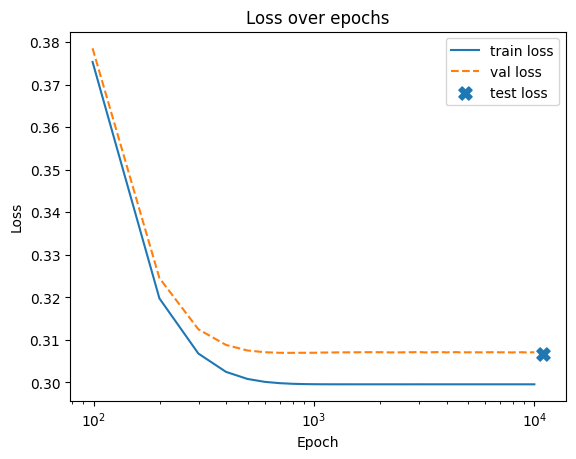

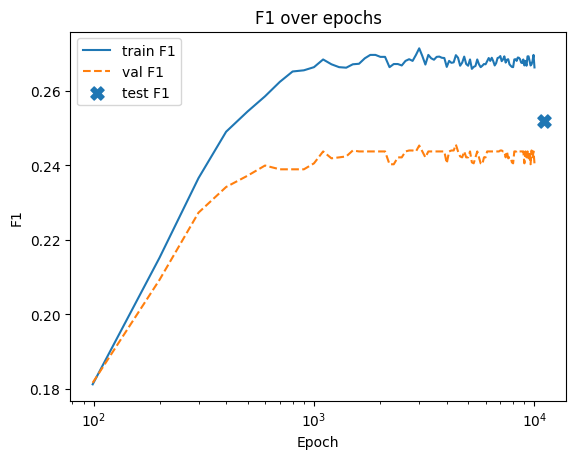

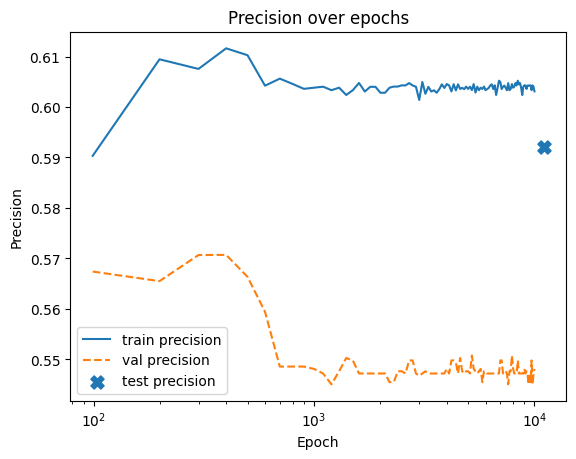

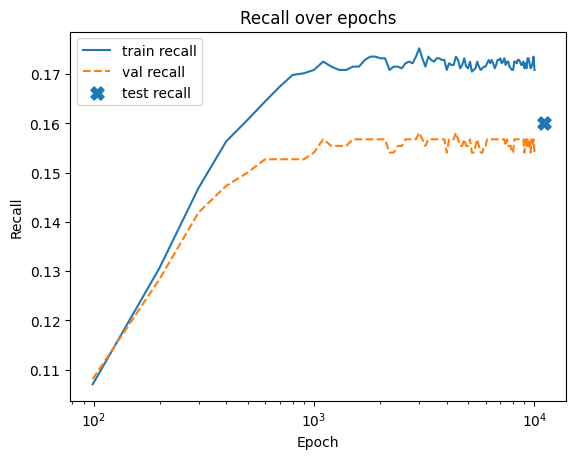

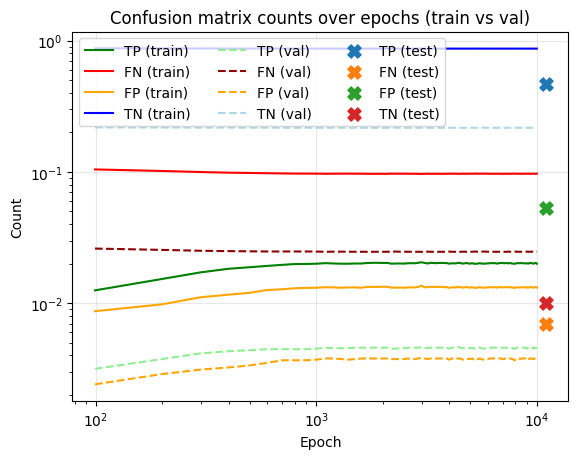

In [56]:
X_te = torch.from_numpy(X_test.astype(np.float32)).to(device)
y_te = torch.from_numpy(y_test.astype(np.float32)).to(device)
test_res = evaluate(X_te, y_te)
t_loss, t_acc, t_cm, t_prec, t_rec, t_f1 = test_res
print(t_loss, t_f1, t_prec, t_rec)

plot_eval(history_nn, test_res)
plot_cm(history_nn, test_res)

### Różnice pytorch vs numpy
- Przede wszystkim nie trzeba męczyć się implementacją, jest dużo przyjemniejsza.
- Pytorch może działać na GPU, co jest fajną opcją.
- Z początku uczenie pytorcha zajęło znacząco dłużej, niż moja implementacja numpy. Trochę się nagimnastykowałem, ale zaczęło działać szybko i na gpu i na cpu.
- Pytorch wykonuje więcej pracy związanej z gradientami - trzyma pośrednie wartości itp, co ma sens dla dużych modeli, acz niekoniecznie dla jednego neuronu. To pewnie jest przyczyną tego, że uczy się dłużej.

### Podsumowanie
(Tutaj ze zmianą: zapisywanie wyników co 100 epochów)
| Implementacja | Epoki | Learning rate | Czas uczenia | Test: Loss | Test: F1 | Test: precyzja | Test: recall |
|---:|---:|---:|---:|---:|---:|---:|---:|
| Numpy | 1000 | 0.01 | 4 s | 0.307 | 0.253 | 0.591 | 0.160 |
| Numpy | 1000 | 0.001 | 3 s | 0.362 | 0.192 | 0.583 | 0.11 |
| Numpy | 10000 | 0.001 | 30 s | 0.307 | 0.252 | 0.590 | 0.160 |
| Numpy | 1000 | 0.1 | 5 s | 0.307 | 0.253 | 0.591 | 0.161 |
| Pytorch | 1000 | 0.01 | 9 s | 0.310 | 0.252 | 0.592 | 0.160 |
| Pytorch | 1000 | 0.001 | 9 s | 0.370 | 0.148 | 0.574 | 0.085 |
| Pytorch | 10000 | 0.001 | 46 s | 0.307 | 0.252 | 0.591 | 0.160 |
| Pytorch | 1000 | 0.1 | 6 s | 0.307 | 0.254 | 0.593 | 0.161 |



### Wnioski
- Wyniki modelu są lekko mówiąc słabe. Widać na wykresach, że od pewnego momentu (koło 100/1000 epoki) model nic już się nie uczy.
- Moje zapisywanie danych co epokę istotnie spowalniało uczenie. Tymbardziej, gdy podłączałem model z pytorcha do gpu.
- Z powodu niezbalansowania klas, w obu implementacjach model uczył się premiować odpowiedź "nie". Precyzja jest dużo wyższa niż recall.

### Taki smaczek

Perceptron wg. Nano Banana. Co poszło źle?


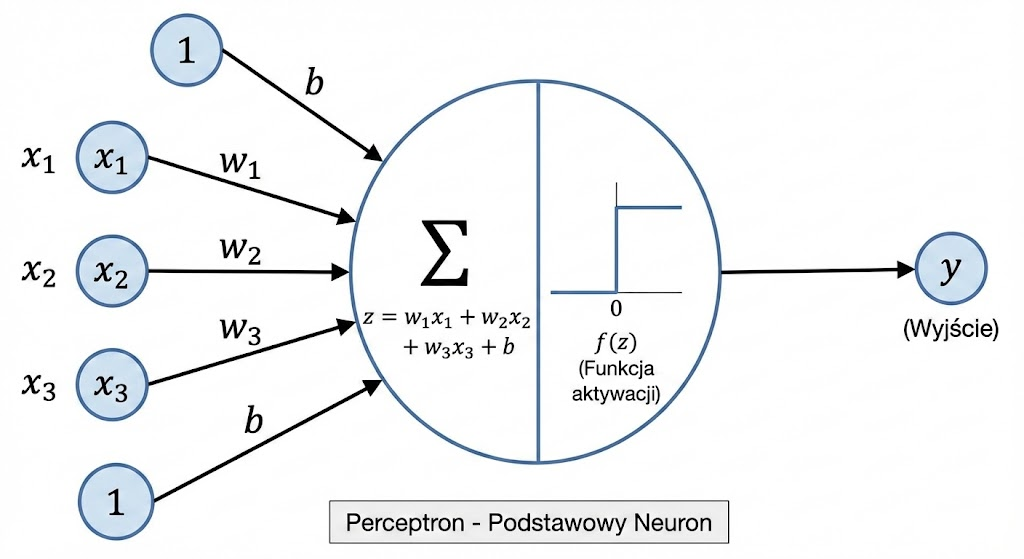

Na wejściu są dwa biasy, i funkcja aktywacji jest taka, co jej nie pouczysz (skok). Ale nie wiem, czy o to chodzi.